In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#cold imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train_data=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_features=train_data.drop("label",axis=1)
train_label=train_data.label.values


In [5]:
#Normalizing the pixel values between 0-1 , dividing them by 255.0
train_features=train_features.values/255.0

In [6]:
#splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(train_features,train_label,test_size=0.2,random_state=42)

In [7]:
# converting the numpy arrays to torch tensors

X_train=torch.from_numpy(X_train)
X_test=torch.from_numpy(X_test)
y_train=torch.from_numpy(y_train).long()
y_test=torch.from_numpy(y_test).long()

In [8]:
#creating datasets and dataloaders

train_set=torch.utils.data.TensorDataset(X_train,y_train)
test_set=torch.utils.data.TensorDataset(X_test,y_test)

In [9]:
batch_size=256
train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True)



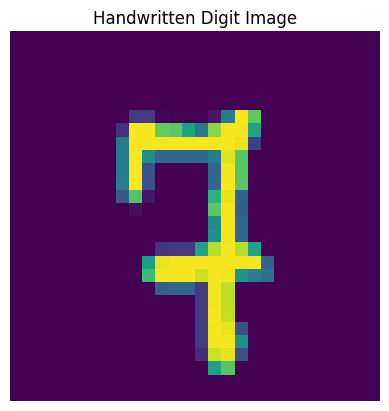

In [10]:
#visualizing the digits

def visualize_image(data, index,pred=False, val=0):
    '''This funtion can be used to visualize the images'''
    plt.imshow(data[index].reshape(28,28))
    plt.axis("off")
    plt.title("Handwritten Digit Image")
    plt.show()
visualize_image(X_train, 11)

In [11]:
class mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(28*28,256) #28*28 is the input dim of image
        self.l2=nn.Linear(256,128)
        self.l3=nn.Linear(128,64)
        self.l4=nn.Linear(64,32)
        self.l5=nn.Linear(32,10)   #no.of labels = 10(0-9)
        self.dropout=nn.Dropout(p=0.2)
        self.log_softmax=F.log_softmax
    def forward(self,x):
        x=self.dropout(F.relu(self.l1(x)))
        x=self.dropout(F.relu(self.l2(x)))
        x=self.dropout(F.relu(self.l3(x)))
        x=self.dropout(F.relu(self.l4(x)))
        x=self.dropout(self.log_softmax(self.l5(x),dim=1))
        return x
                       

In [13]:
#training loop
model=mnist()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
loss_fn=nn.NLLLoss()
epochs=50
train_losses, test_losses = [], []
step=0
limit=50
for epoch in range(epochs):
    running_loss=0
    for X_batch,y_batch in train_loader:
        output=model(X_batch.float())
        loss=loss_fn(output,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if step%limit==0:
        test_loss=0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for data,label in test_loader:
                pred=model(data.float())
                t_loss=loss_fn(pred,label)
                test_loss+=t_loss
                logits = model(data.float())  # Get logits from the model
                predicted_class = torch.argmax(logits, dim=1)  # Get the class with the highest score
                equals = predicted_class == label  # Compare predictions with the ground truth labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()  # Accumulate accuracy
        model.train()

        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))



Epoch: 1/50..  Training Loss: 0.633..  Test Loss: 0.272..  Test Accuracy: 0.922
Epoch: 2/50..  Training Loss: 0.287..  Test Loss: 0.208..  Test Accuracy: 0.946
Epoch: 3/50..  Training Loss: 0.233..  Test Loss: 0.184..  Test Accuracy: 0.953
Epoch: 4/50..  Training Loss: 0.210..  Test Loss: 0.167..  Test Accuracy: 0.959
Epoch: 5/50..  Training Loss: 0.212..  Test Loss: 0.168..  Test Accuracy: 0.960
Epoch: 6/50..  Training Loss: 0.192..  Test Loss: 0.193..  Test Accuracy: 0.955
Epoch: 7/50..  Training Loss: 0.182..  Test Loss: 0.155..  Test Accuracy: 0.965
Epoch: 8/50..  Training Loss: 0.172..  Test Loss: 0.155..  Test Accuracy: 0.964
Epoch: 9/50..  Training Loss: 0.179..  Test Loss: 0.184..  Test Accuracy: 0.959
Epoch: 10/50..  Training Loss: 0.172..  Test Loss: 0.160..  Test Accuracy: 0.959
Epoch: 11/50..  Training Loss: 0.164..  Test Loss: 0.135..  Test Accuracy: 0.966
Epoch: 12/50..  Training Loss: 0.166..  Test Loss: 0.160..  Test Accuracy: 0.964
Epoch: 13/50..  Training Loss: 0.158.

In [36]:

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Predicted Class: 4, Actual Class: 4


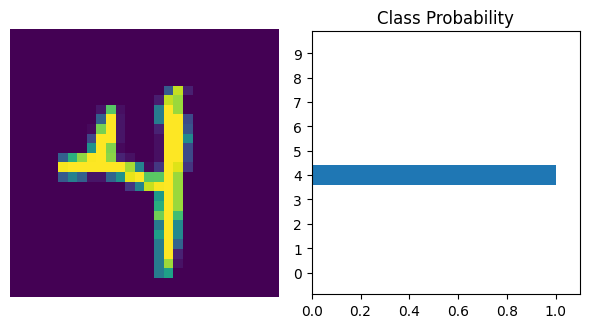

In [63]:
%matplotlib inline
def make_prediction(data, model, sample_index=42):
    """
    Make a prediction on a specific sample and compare it with the actual label.
    
    Args:
    - data: The data loader (e.g., test_loader).
    - model: The trained PyTorch model.
    - sample_index: The index of the image sample to predict.
    
    Returns:
    - The predicted class and the actual class for the given sample.
    """
    # Get a batch of images and labels from the data loader
    images, labels = next(iter(data))
    
    # Select the specific image for prediction
    img = images[sample_index].view(1, 784)  # Flatten the image

    # Disable gradient calculations for inference
    with torch.no_grad():
        logps = model(img.float())  # Get the log-probabilities from the model

    # Convert log-probabilities to probabilities
    ps = torch.exp(logps)
    
    # Get the predicted class (class with the highest probability)
    predicted_class = torch.argmax(ps, dim=1)
    
    # Get the actual label for the selected sample
    actual_class = labels[sample_index]
    
    # Visualize the image and its predictions
    view_classify(img.view(1, 28, 28), ps)

    # Print and return the predicted and actual class
    print(f"Predicted Class: {predicted_class.item()}, Actual Class: {actual_class.item()}")
    return predicted_class.item(), actual_class.item()

# Call the function and pass the test_loader, model, and sample index
predicted, actual = make_prediction(test_loader, model, sample_index=42)
